In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"

In [2]:
"""Improve name detector with both accuracy and inference time
"""

import sys
import os

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Make this script able to call lib module from parent level
sys.path.append(os.getcwd())
sys.path.append('../../line_detector/')

from lib.fast_rcnn.config import cfg,cfg_from_file
import detector

DATA_DIR = '/home/ducna/share/Data/new_cropped/images'

In [3]:
# Config file
cfg_from_file('../../line_detector/text.yml')
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)

# Load pb graph
with tf.gfile.FastGFile('../../line_detector/models/ctpn.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')

sess.run(tf.global_variables_initializer())

In [4]:
# Load model
from sklearn.externals import joblib

gbc = joblib.load('/home/ducna/share/Classifier/region/gbc.sav')

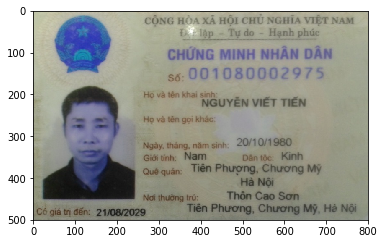

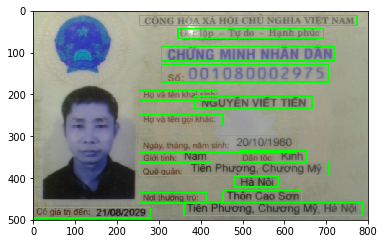

In [8]:
# Random a picture
import random

img_path = os.path.join(DATA_DIR, 
                        random.choice(os.listdir(DATA_DIR)))
img = cv2.imread(img_path)
plt.imshow(img)
plt.show()


def draw_boxes(img, boxes, color=(0, 255, 0), title=None):
    """Draw boxes in image given coordinates
    """
    clone = np.copy(img)
    for box in boxes:
        cv2.rectangle(clone, box[0], box[1], color, 2)

    if title:
        plt.title(title)
        
    plt.imshow(clone)
    plt.show()
    
    return clone


# Detect lines and show result
boxes = detector.query_pb(sess, cfg, img)

_ = draw_boxes(img, boxes)

In [9]:
from collections import OrderedDict
import pandas as pd

boxes_dict = OrderedDict({
    'x1': [box[0][0] for box in boxes], 
    'y1': [box[0][1] for box in boxes], 
    'x2': [box[1][0] for box in boxes], 
    'y2': [box[1][1] for box in boxes], 
})
boxes_df = pd.DataFrame.from_dict(boxes_dict)
boxes_df

,x1,y1,x2,y2
0,493,335,653,363
1,453,430,640,457
2,253,190,440,214
3,253,299,626,338
4,253,248,453,274
5,360,458,786,489
6,0,469,280,495
7,253,434,413,459
8,480,396,586,421
9,346,43,693,67


CPU times: user 720 ms, sys: 60 ms, total: 780 ms
Wall time: 164 ms


/home/hoanghiep/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


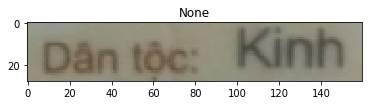

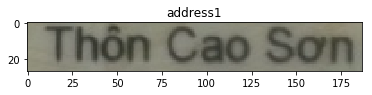

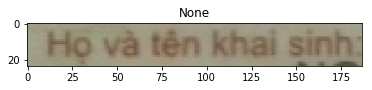

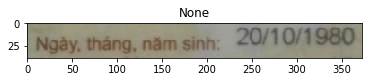

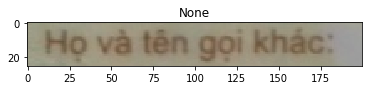

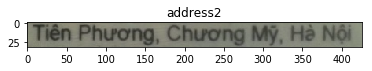

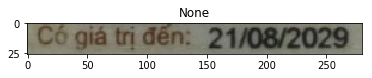

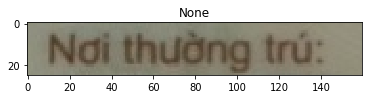

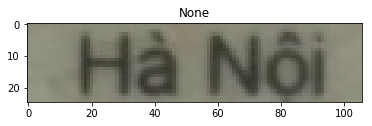

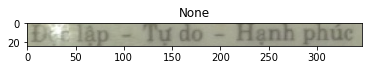

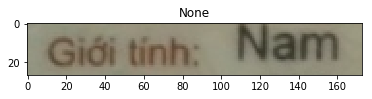

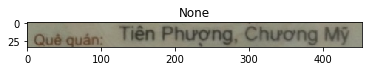

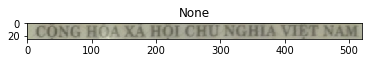

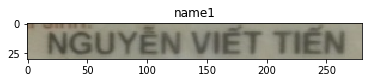

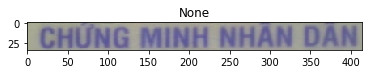

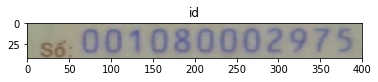

In [10]:
%time labels = gbc.predict(boxes_df)
for i, box in enumerate(boxes):
    (x1, y1), (x2, y2) = box
    plt.imshow(img[y1:y2, x1:x2])
    plt.title(labels[i])
    plt.show()

In [17]:
def box_threshold(box, threshold, margin):
    """Threshold by pixel, get all pixels to the right of the threshold
    """
    (x1, y1), (x2, y2) = box
    return [(max(x1, threshold), y1-margin),
            (x2, y2+margin)]


def extract_id(img, threshold=360):
    id_box = None
    boxes = detector.query_pb(sess, cfg, img)
    boxes_dict = OrderedDict({
        'x1': [box[0][0] for box in boxes], 
        'y1': [box[0][1] for box in boxes], 
        'x2': [box[1][0] for box in boxes], 
        'y2': [box[1][1] for box in boxes], 
    })
    boxes_df = pd.DataFrame.from_dict(boxes_dict)
    
    labels = gbc.predict(boxes_df)
    
    for i, box in enumerate(boxes):
        if labels[i] == 'id':
            id_box = box_threshold(box, threshold, margin=0)
            (x1, y1), (x2, y2) = id_box
    return id_box

/home/hoanghiep/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


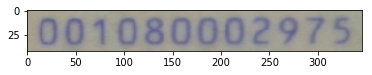

In [19]:
(x1, y1), (x2, y2) = extract_id(img)
plt.imshow(img[y1:y2, x1:x2])

In [26]:
import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm

with open('id.csv', 'w') as f:
    f.write('id,x1,y1,x2,y2,class\n')
    
    for img_name in tqdm(os.listdir(DATA_DIR)):
        img_path = os.path.join(DATA_DIR, img_name)
        img = cv2.imread(img_path)
        box = extract_id(img)
        if box is not None:
            (x1, y1), (x2, y2) = box
            f.write('{},{},{},{},{},id\n'.format(img_name, x1, y1, x2, y2))

100%|██████████| 432/432 [14:38<00:00,  2.03s/it]
